In [1]:
# Data processing code is the same from last week, go to next cell
import pandas as pd
from pandas import Series,DataFrame

"""
IMPORTANT NOTE: If parsing Excel files fails, conda install xlrd AND openpyxl
"""

# BLS dataset for labor participation
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('STATE')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('STATE')
Dem_Rep = pd.DataFrame(Dem['GENERAL %'] - Rep['GENERAL %'])
Dem_Rep.rename(columns={'GENERAL %': 'PercentDemocratHasOverRepublican'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

# Load income per capita as response variable
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income = income[[1, 2]]
income.set_index('State')

# Merge data sets
data = pd.merge(Dem_Rep, income, left_on='STATE', right_on='State')
data = pd.merge(data, bls12).drop(['STATE'], axis=1).set_index('State')
data.columns = ['Percent Democrat Has Over Republican', 'IncomePerCapita',
                'Labor Participation', 'Unemployment Rate']
data['Percent Democrat Has Over Republican'] = pd.to_numeric(data['Percent Democrat Has Over Republican'])
data['IncomePerCapita'] = data['IncomePerCapita'].apply(lambda x: x.replace('$', '').replace(',', ''))
data['IncomePerCapita'] = pd.to_numeric(data['IncomePerCapita'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment Rate'] = pd.to_numeric(data['Unemployment Rate'])
data.head()

,Percent Democrat Has Over Republican,IncomePerCapita,Labor Participation,Unemployment Rate
State,,,,
Alabama,-0.221868,23606,53.4,8.0
Alaska,-0.139889,33062,63.4,7.1
Arizona,-0.090648,25715,55.5,8.3
Arkansas,-0.236879,22883,54.8,7.6
California,0.231186,30441,56.6,10.4


Association between Percent Democrat Has Over Republican and IncomePerCapita
(0.67728941142862042, 2.5603121647192332e-08)


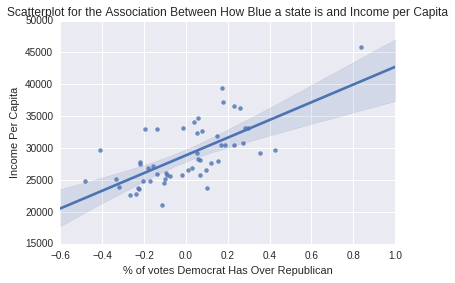

In [2]:
# Strong correlation between "Percent Democrat Has Over Republican" and "IncomePerCapita"
import scipy.stats
print ('Association between Percent Democrat Has Over Republican and IncomePerCapita')
print (scipy.stats.pearsonr(data['Percent Democrat Has Over Republican'], data['IncomePerCapita']))

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
scat1 = seaborn.regplot(x="Percent Democrat Has Over Republican", y="IncomePerCapita", fit_reg=True, data=data)
plt.xlabel('% of votes Democrat Has Over Republican')
plt.ylabel('Income Per Capita')
plt.title('Scatterplot for the Association Between How Blue a state is and Income per Capita')
plt.show()

In [3]:
data['Unemployment Rate'].describe()
def unemploy_grp (row):
   if row['Unemployment Rate'] <= 6.0:
      return 1
   elif row['Unemployment Rate'] >= 8.5:
      return 3
   else:
      return 2
   
data['unemploy_grp'] = data.apply(lambda row: unemploy_grp(row),axis=1)

chk1 = data['unemploy_grp'].value_counts(sort=False, dropna=False)
print(chk1)

sub1=data[(data['unemploy_grp']== 1)]
sub2=data[(data['unemploy_grp']== 2)]
sub3=data[(data['unemploy_grp']== 3)]

1    14
2    23
3    16
Name: unemploy_grp, dtype: int64


association between %Democrat>Rep and IncomePerCapita for LOW Unemployment
(0.44372422690011448, 0.11198977646880813)
Axes(0.125,0.125;0.775x0.775)


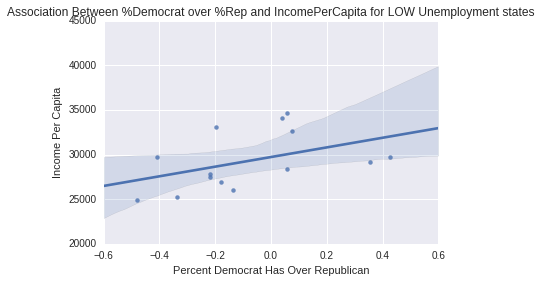

In [4]:
print ('association between %Democrat>Rep and IncomePerCapita for LOW Unemployment')
print (scipy.stats.pearsonr(sub1['Percent Democrat Has Over Republican'], sub1['IncomePerCapita']))

scat1 = seaborn.regplot(x="Percent Democrat Has Over Republican", y="IncomePerCapita", data=sub1)
plt.xlabel('Percent Democrat Has Over Republican')
plt.ylabel('Income Per Capita')
plt.title('Association Between %Democrat over %Rep and IncomePerCapita for LOW Unemployment states')
print(scat1)

association between %Democrat>Rep and IncomePerCapita for Middle 2 Quartile of Unemployment
(0.75779084918312978, 2.8130272361891836e-05)
Axes(0.125,0.125;0.775x0.775)


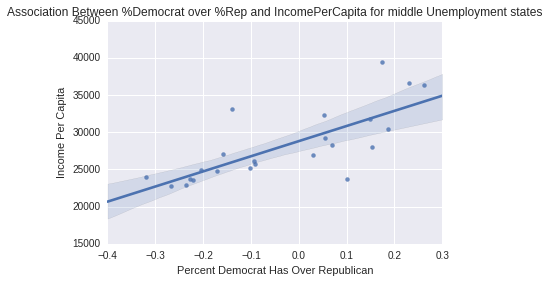

In [5]:
print ('association between %Democrat>Rep and IncomePerCapita for Middle 2 Quartile of Unemployment')
print (scipy.stats.pearsonr(sub2['Percent Democrat Has Over Republican'], sub2['IncomePerCapita']))

scat2 = seaborn.regplot(x="Percent Democrat Has Over Republican", y="IncomePerCapita", data=sub2)
plt.xlabel('Percent Democrat Has Over Republican')
plt.ylabel('Income Per Capita')
plt.title('Association Between %Democrat over %Rep and IncomePerCapita for middle Unemployment states')
print(scat2)

association between %Democrat>Rep and IncomePerCapita for 4th Quartile of Unemployment
(0.8791384857344855, 7.2965646276284775e-06)
Axes(0.125,0.125;0.775x0.775)


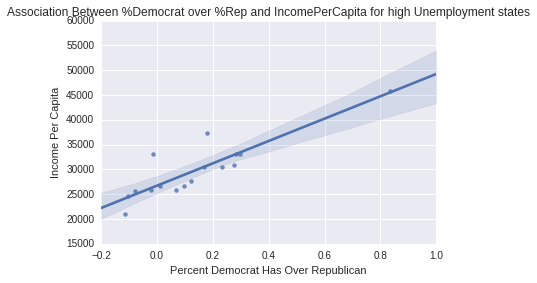

In [6]:
print ('association between %Democrat>Rep and IncomePerCapita for 4th Quartile of Unemployment')
print (scipy.stats.pearsonr(sub3['Percent Democrat Has Over Republican'], sub3['IncomePerCapita']))

scat3 = seaborn.regplot(x="Percent Democrat Has Over Republican", y="IncomePerCapita", data=sub3)
plt.xlabel('Percent Democrat Has Over Republican')
plt.ylabel('Income Per Capita')
plt.title('Association Between %Democrat over %Rep and IncomePerCapita for high Unemployment states')
print(scat3)